In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv('/content/drive/My Drive/cgcnn/heusler_magnetic.csv')

# Display initial data
df.head()


,formula,heusler type,num_electron,struct type,latt const,tetragonality,e_form,pol fermi,gap width,stability,mu_b,mu_b saturation
0,V2ScAl,Full Heusler,16,D022,5.49,1.5610,0.046,0.10,No gap,False,0.0002,0.03
1,V2ScGa,Full Heusler,16,D022,5.43,1.5893,-0.014,36.93,No gap,True,0.1775,25.88
2,V2ScIn,Full Heusler,16,D022,5.66,1.5583,0.191,34.28,No gap,False,0.1624,21.32
3,V2ScSi,Full Heusler,17,D022,5.34,1.5993,-0.122,19.59,No gap,True,0.6638,101.12
4,V2ScGe,Full Heusler,17,D022,5.39,1.6104,-0.087,10.09,No gap,True,0.7492,110.21


In [ ]:
# Remove rows with missing values
df = df.dropna()

# Encode stability column to numerical labels
df['stability'] = df['stability'].apply(lambda x: 1 if x == 'TRUE' or x == True else 0)

# Select relevant features for predicting stability
features = ['num_electron', 'latt const', 'tetragonality', 'e_form', 'pol fermi', 'mu_b', 'mu_b saturation']
X = df[features]
y = df['stability']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


<ipython-input-3-8f4a50c6abae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stability'] = df['stability'].apply(lambda x: 1 if x == 'TRUE' or x == True else 0)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00       145

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215

ROC-AUC: 1.000


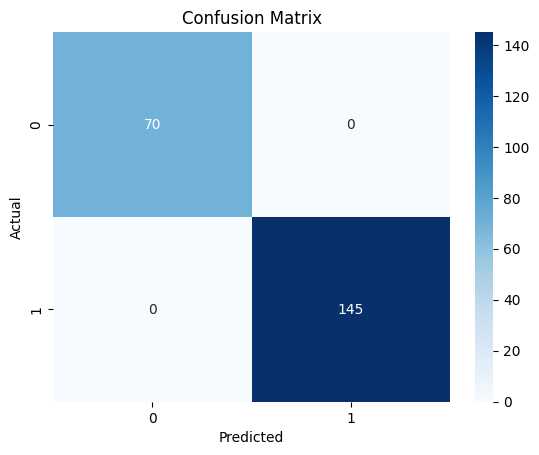

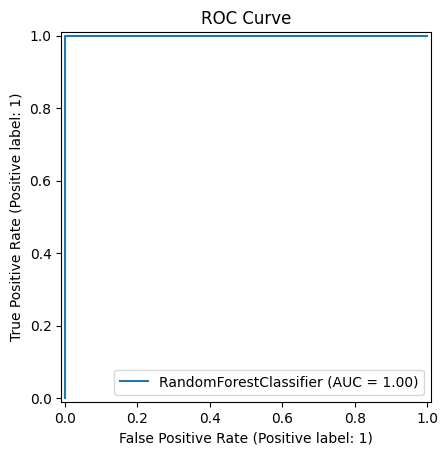

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Initialize and train RandomForest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predictions on test set
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title('ROC Curve')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare real data for GAN
real_data = torch.tensor(X_scaled, dtype=torch.float32).to(device)
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
# GAN parameters
noise_dim = 10
data_dim = real_data.shape[1]

# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Initialize models
G = Generator(noise_dim, data_dim).to(device)
D = Discriminator(data_dim).to(device)

# Optimizers & Loss
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=2e-4)
opt_D = optim.Adam(D.parameters(), lr=2e-4)


Epoch [50/300] | D_loss: 1.0856 | G_loss: 0.7455
Epoch [100/300] | D_loss: 0.8450 | G_loss: 0.9912
Epoch [150/300] | D_loss: 0.9741 | G_loss: 1.0590
Epoch [200/300] | D_loss: 0.7669 | G_loss: 1.3927
Epoch [250/300] | D_loss: 1.3624 | G_loss: 0.8820
Epoch [300/300] | D_loss: 1.0706 | G_loss: 1.0775


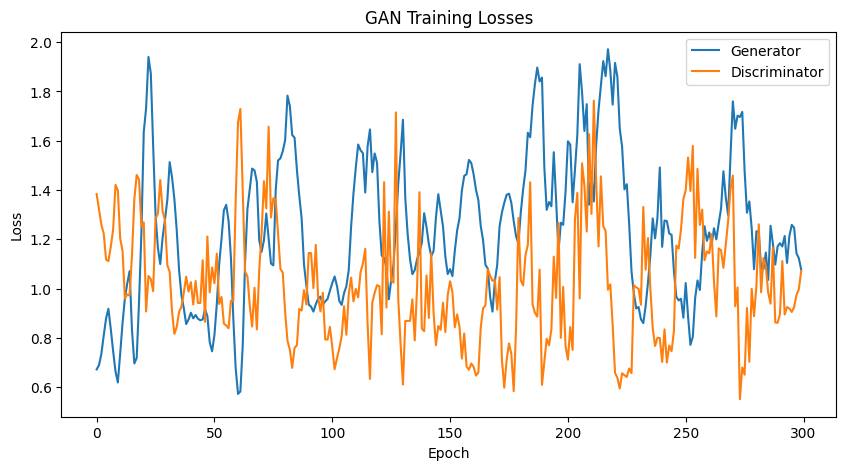

In [ ]:
epochs = 300
G_losses, D_losses = [], []

for epoch in range(epochs):
    for real_batch, in dataloader:
        batch_size = real_batch.size(0)

        # Real & Fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_batch = G(z).detach()
        loss_D = criterion(D(real_batch), real_labels) + criterion(D(fake_batch), fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_batch = G(z)
        loss_G = criterion(D(fake_batch), real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {loss_D:.4f} | G_loss: {loss_G:.4f}")

# Plot GAN training losses
plt.figure(figsize=(10,5))
plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator')
plt.title('GAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
G.eval()
with torch.no_grad():
    synthetic_samples = 500
    noise = torch.randn(synthetic_samples, noise_dim).to(device)
    synthetic_data = G(noise).cpu().numpy()

# Reverse scaling to original feature space
synthetic_data_original = scaler.inverse_transform(synthetic_data)
df_synthetic = pd.DataFrame(synthetic_data_original, columns=features)


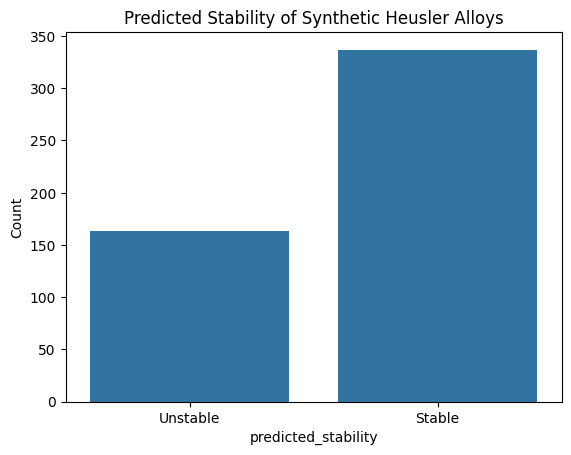

In [ ]:
# Predict stability using trained classifier
synthetic_scaled = scaler.transform(df_synthetic)
synthetic_stability_pred = clf.predict(synthetic_scaled)

df_synthetic['predicted_stability'] = synthetic_stability_pred

# Distribution of predicted stability
sns.countplot(x='predicted_stability', data=df_synthetic)
plt.title('Predicted Stability of Synthetic Heusler Alloys')
plt.xticks([0,1], ['Unstable','Stable'])
plt.ylabel('Count')
plt.show()


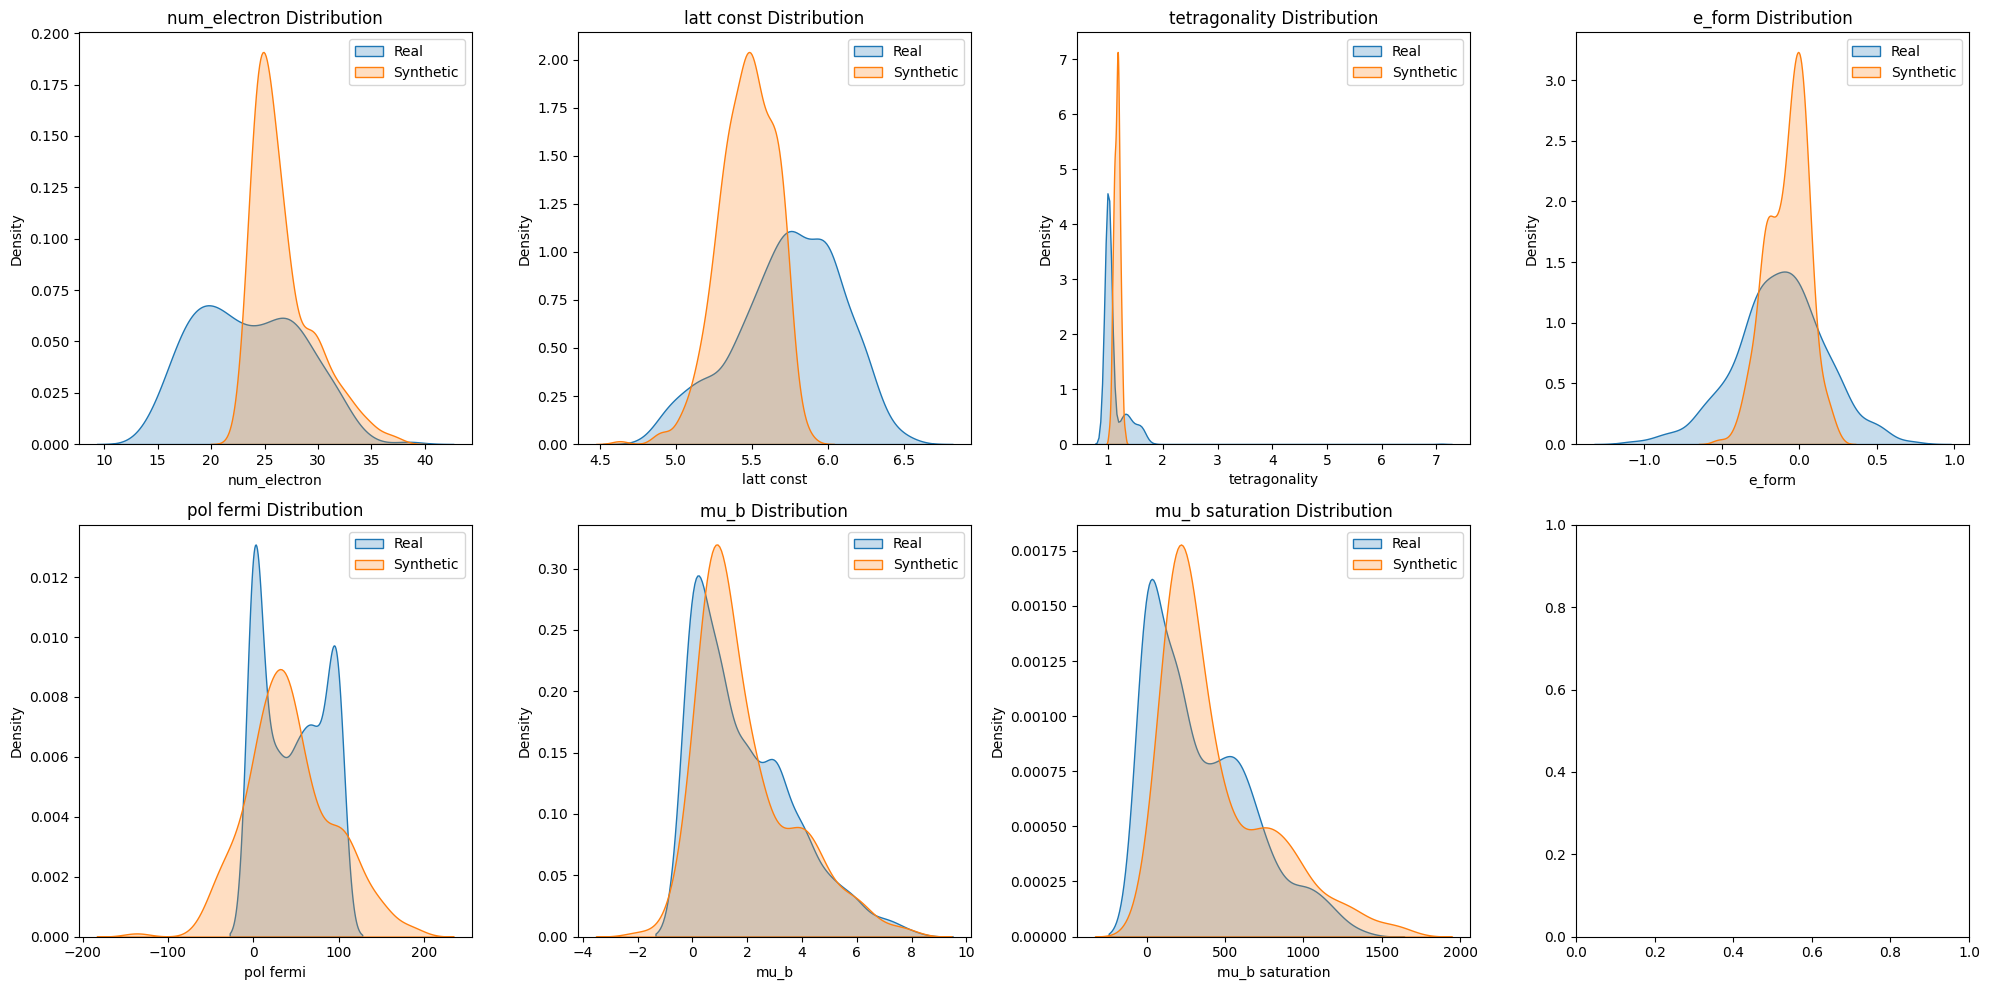

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.kdeplot(df[feature], label='Real', ax=axes[i], fill=True)
    sns.kdeplot(df_synthetic[feature], label='Synthetic', ax=axes[i], fill=True)
    axes[i].set_title(f'{feature} Distribution')
    axes[i].legend()

plt.tight_layout()
plt.show()
